# FER2013 preprocessing for MobileNetV2(GrayScale  48x48)

- Filters corrupted/low-quality images
- Rescales pixel values and applies mean-std normalization
- Drop selected emotion classes
- Splits into train/validation/test sets
- Saves images only if not already processed
- Suitable for: MobileNetV2 training on grayscale FER2013 data


## Imports & Configuration

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Configuration
plt.style.use('ggplot')
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"OpenCV Version: {cv2.__version__}")

# Define constants
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
INPUT_SHAPE = (*IMG_SIZE, 1)  # Grayscale single channel


TensorFlow Version: 2.13.0
OpenCV Version: 4.8.0


In [32]:
# Define base directory and paths
BASE_DIR = '../../data/raw/fer2013/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

#Update the classes
SELECTED_CLASSES = ["angry", "happy", "sad", "surprise", "neutral"]
NUM_CLASSES = len(SELECTED_CLASSES)

print(f"Selected classes: {SELECTED_CLASSES}")
print(f"Input shape: {INPUT_SHAPE}")

#print data summary
def count_class_samples(directory, valid_classes):
    class_counts = Counter()
    for emotion in os.listdir(directory):
        if emotion not in valid_classes:
            continue
        emotion_path =  os.path.join(directory, emotion)
        class_counts[emotion] = len(os.listdir(emotion_path))
    return class_counts

train_counts_raw = count_class_samples(TRAIN_DIR, SELECTED_CLASSES)
test_counts_raw = count_class_samples(TEST_DIR, SELECTED_CLASSES)

print("\nClass-wise raw train samples:")
print(train_counts_raw)
print("\nClass-wise raw test samples:")
print(test_counts_raw)
print(f"\nTotal raw train samples: {sum(train_counts_raw.values())}")
print(f"Total raw test samples: {sum(test_counts_raw.values())}")



Selected classes: ['angry', 'happy', 'sad', 'surprise', 'neutral']
Input shape: (48, 48, 1)

Class-wise raw train samples:
Counter({'happy': 7215, 'neutral': 4965, 'sad': 4830, 'angry': 3995, 'surprise': 3171})

Class-wise raw test samples:
Counter({'happy': 1774, 'sad': 1247, 'neutral': 1233, 'angry': 958, 'surprise': 831})

Total raw train samples: 24176
Total raw test samples: 6043


## Load and Preprocess Data with Filtering

In [9]:
def is_image_valid(img_path):
    """
    check image validity: grayscale shape, not blank, not corrupted
    """
    try:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None or img.shape != IMG_SIZE:
            return False
        if np.var(img) < 5:
            return False
        return True
    except:
        return False
        
def preprocess_image(img_path):
    """
    Basic preprocessing for FER2013 images:
    - Load as grayscale
    - Normalize to [0, 1]
    - Add channel dimension
    """
    # Load image (already grayscale 48x48)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize to [0, 1]
    img_normalized = img.astype(np.float32) / 255.0
    
    # Add channel dimension for CNN: (48, 48) → (48, 48, 1)
    img_final = np.expand_dims(img_normalized, axis=-1)
    
    return img_final

def load_and_preprocess_data(directory, valid_classes):
    """
    Load images and labels from directory, apply preprocessing
    """
    images = []
    labels = []
    corrupted_count = 0
    
    for emotion in os.listdir(directory):
        if emotion not in valid_classes:
            continue
        emotion_path = os.path.join(directory, emotion)
        for img_file in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_file)
            if not is_image_valid(img_path):
                corrupted_count += 1
                continue
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(emotion)
    return np.array(images), np.array(labels), corrupted_count

X_train_full, y_train_full, corrupted_train = load_and_preprocess_data(TRAIN_DIR, SELECTED_CLASSES)
X_test, y_test, corrupted_test = load_and_preprocess_data(TEST_DIR, SELECTED_CLASSES)

print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Corrupted train images removed: {corrupted_train}")
print(f"Corrupted test images removed: {corrupted_test}")

# Applies global mean-std normalization using training set mean and std
mean = np.mean(X_train_full)
std = np.std(X_train_full)
X_train_full = (X_train_full - mean) / std
X_test = (X_test - mean) / std

Training data shape: (24164, 48, 48, 1)
Test data shape: (6042, 48, 48, 1)
Corrupted train images removed: 12
Corrupted test images removed: 1


##  Train/Validation Split

In [13]:
# Splitting training set into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Convert string labels to numerical labels
label_to_index = {emotion: idx for idx, emotion in enumerate(SELECTED_CLASSES)}
index_to_label = {idx: emotion for emotion, idx in label_to_index.items()}

# Convert string labels to numerical
y_train_num = np.array([label_to_index[label] for label in y_train])
y_val_num = np.array([label_to_index[label] for label in y_val])
y_test_num = np.array([label_to_index[label] for label in y_test])

# One-hot encode labels
y_train_encoded = to_categorical(y_train_num, num_classes=NUM_CLASSES)
y_val_encoded = to_categorical(y_val_num, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test_num, num_classes=NUM_CLASSES)

# Calculate class weights for handling imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_num),
    y=y_train_num
)
class_weights = dict(enumerate(class_weights))

print("\nClass weights for handling imbalance:")
for idx, weight in class_weights.items():
    print(f"{index_to_label[idx]}: {weight:.2f}")

X_train shape: (19331, 48, 48, 1)
X_val shape: (4833, 48, 48, 1)

Class weights for handling imbalance:
angry: 1.21
happy: 0.67
sad: 1.00
surprise: 1.52
neutral: 0.97


## Data Augmentation


Augmented training samples:


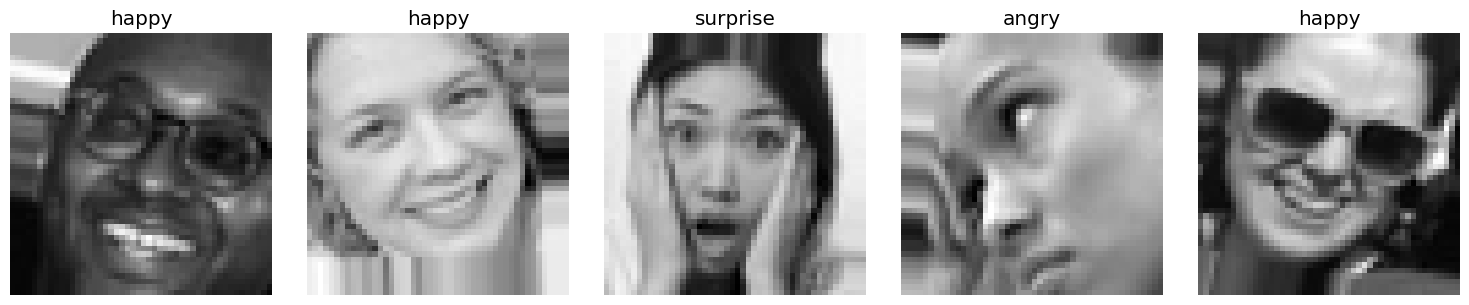

In [16]:
# Create data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=15,          # ±15 degrees
    width_shift_range=0.1,      # ±10% horizontal shift
    height_shift_range=0.1,     # ±10% vertical shift
    brightness_range=[0.9, 1.1], # ±10% brightness
    zoom_range=0.1,             # ±10% zoom
    horizontal_flip=True,       # 50% chance (be careful with asymmetric emotions)
    fill_mode='nearest'         # Fill missing pixels
)

# Validation/test generator (only normalization)
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(
    X_train,
    y_train_encoded,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = test_datagen.flow(
    X_test,
    y_test_encoded,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Visualize augmented samples
def plot_augmented_samples(generator, n_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        # Get a batch of augmented images
        for X_batch, y_batch in generator:
            # Convert grayscale to RGB for display
            img = np.squeeze(X_batch[0])
            label = index_to_label[np.argmax(y_batch[0])]
            
            plt.subplot(1, n_samples, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(label)
            plt.axis('off')
            break  
    plt.tight_layout()
    plt.show()

print("\nAugmented training samples:")
plot_augmented_samples(train_generator)

## Save Processed Data

In [17]:
PROCESSED_DIR = Path("../../data/processed/FC211042_Heshani")
train_out, test_out = PROCESSED_DIR / "train", PROCESSED_DIR / "test"
train_out.mkdir(parents=True, exist_ok=True)
test_out.mkdir(parents=True, exist_ok=True)

SAVE_IMAGES = not any(train_out.glob("*.jpg")) or not any(test_out.glob("*.jpg"))


if SAVE_IMAGES:
    def save_images(array, labels, root_dir):
        for idx, (img, label_vec) in enumerate(zip(array, labels)):
            class_name = index_to_label[int(np.argmax(label_vec))]
            class_dir = root_dir / class_name
            class_dir.mkdir(exist_ok=True)
            img_uint8 = (img.squeeze() * 255).astype("uint8")
            file_path = class_dir / f"{idx:06d}.jpg"
            if not file_path.exists():
                cv2.imwrite(str(file_path), img_uint8)

    save_images(X_train, y_train_encoded, train_out)
    save_images(X_val, y_val_encoded, train_out)
    save_images(X_test, y_test_encoded, test_out)
    print("Preprocessing completed. Data saved as JPG files.")
else:
    print("Preprocessed images already exist. Skipping saving step.")

✅ Preprocessing completed. Data saved as JPG files.


In [37]:
# Calculate class counts after preprocessing
def count_classes_from_labels(labels_array):
    return Counter(labels_array)

train_class_counts_post = count_classes_from_labels(y_train)
val_class_counts_post = count_classes_from_labels(y_val)
test_class_counts_post = count_classes_from_labels(y_test)

print("\n----Dataset Preprocessing Summary----")
print(f"\nOriginal train samples: {sum(train_counts_raw.values())}")
print(f"Original test samples: {sum(test_counts_raw.values())}")

print(f"Filtered total train samples: {X_train_full.shape[0]}")
print(f"Filtered total test samples: {X_test.shape[0]}")

print("\nClass-wise train counts after preprocessing + split:")
print(train_class_counts_post)
print("Class-wise validation counts:")
print(val_class_counts_post)
print("Class-wise test counts:")
print(test_class_counts_post)

print(f"\nRemoved corrupted/low-quality train images: {corrupted_train}")
print(f"Removed corrupted/low-quality test images: {corrupted_test}")
print(f"\nProcessed data saved in: {PROCESSED_DIR}")



----Dataset Preprocessing Summary----

Original train samples: 24176
Original test samples: 6043
Filtered total train samples: 24164
Filtered total test samples: 6042

Class-wise train counts after preprocessing + split:
Counter({'happy': 5771, 'neutral': 3970, 'sad': 3863, 'angry': 3191, 'surprise': 2536})
Class-wise validation counts:
Counter({'happy': 1443, 'neutral': 993, 'sad': 966, 'angry': 797, 'surprise': 634})
Class-wise test counts:
Counter({'happy': 1774, 'sad': 1247, 'neutral': 1233, 'angry': 957, 'surprise': 831})

Removed corrupted/low-quality train images: 12
Removed corrupted/low-quality test images: 1

Processed data saved in: ../../data/processed/FC211042_Heshani
